In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import Bio
import json
import collections
import math
import glob
import random
import numpy as np
import matplotlib.cm as cm
from numpy import linspace
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.Data import CodonTable

In [3]:
def cdc(sequence):
    pos = {}
    seq = sequence[3:-3] #removing start/stop codon from sequence
    data = [] # data for each codon position in the sequence: data[codon position, 0 to 2][letter representing data]
    for x in range(0,3):
        pos = {'A' : seq[x::3].count('A'), 'T' : seq[x::3].count('T'), 'G' : seq[x::3].count('G'), 'C' : seq[x::3].count('C')}
        pos['S']  = (pos['G'] + pos['C']) / len(seq[x::3])
        pos['R']  = (pos['A'] + pos['G']) / len(seq[x::3])
        pos['Ai'] = (1 - pos['S']) * pos['R'] 
        pos['Ti'] = (1 - pos['S']) * (1 - pos['R'])
        pos['Gi'] = pos['S'] * pos['R']
        pos['Ci'] = pos['S'] * (1 - pos['R'])
        data.append(pos)

    # building a list of all possible codons (including nonsense codons)
    bases = ['A', 'T', 'G', 'C']
    codons = []
    for one in bases:
        for two in bases:
            for three in bases:
                codons.append(one+two+three)
                
    # removing start/stop codons from calculations
    codons.remove('TAA')
    codons.remove('TGA')
    codons.remove('TAG')
    
    #create list of all codons in the sequence, stored as strings
    codon_list = []
    for x in range(0, len(seq), 3):
        codon_list.append(str(seq[x:x+3]))
    #create a counter dictionary for each codon present in the sequence
    counted_codons = collections.Counter(codon_list)
    number_of_codons = len(codon_list)
    
    #creating a list of tuples; each tuple is (expected codon usage pi, observed codon usage pi-hat) for all 61 possible codons
    codon_usage = []
    expected_usage_numerator = []
    observed_usage = []
    for codon in codons:
        expected_usage_numerator.append(data[0][codon[0]+'i'] * data[1][codon[1]+'i'] * data[2][codon[2]+'i'])
        observed_usage.append(counted_codons[codon] / number_of_codons )
    total_expected_usage = sum(expected_usage_numerator)
    for x in range(0, len(codons)):
        codon_usage.append( (expected_usage_numerator[x] / total_expected_usage, observed_usage[x]) )

    #calculating the CDC
    numerator = exp_squared = obs_squared = 0
    for usage in codon_usage:
        numerator += usage[0]*usage[1]
        exp_squared += usage[0]**2
        obs_squared += usage[1]**2
    
    CDC = 1 - ( numerator / math.sqrt(exp_squared * obs_squared) )
    return CDC

In [4]:
cdc('AGCGGAAAACCAGCGGCG')

0.48972090909454313

In [5]:
records = list(SeqIO.parse("ecoli_genome.gbk", "genbank"))

gene_CDCs = {} #a dictionary with the CDC for each gene, keys = locus tags

for record in records:
    for gene in record.features:
        if gene.type == 'CDS' and (gene.location.end - gene.location.start) % 3 == 0:
            try:
                DNASequence = str(gene.extract(record.seq))
                tag = gene.qualifiers['locus_tag'][0]
                gene_CDCs[tag] = cdc(DNASequence)
            except KeyError:
                next


In [6]:
#generates  dictionary with a randomish probability for each codon || unweighted, each codon has a ~0.0164 probability
def random_codons():
    # building a list of all 61 possible codons
    bases = ['A', 'T', 'G', 'C']
    codons = []
    for one in bases:
        for two in bases:
            for three in bases:
                codons.append(one+two+three)
    codons.remove('TAA')
    codons.remove('TGA')
    codons.remove('TAG')
    
    #creating a list of probabilities, all within between 0 to 1
    random_prob = []
    for x in range(0, len(codons)):
        random_prob.append(random.uniform(0, 1))
    
    #correcting the probabilities so that they sum to 1
    c = 0
    while sum(random_prob) > 1:
        over = sum(random_prob) / len(random_prob)
        if random_prob[c%61] > over:
            random_prob[c%61] -= over
        c+=1
    else:
        random_prob[random.randint(0,60)] += 1 - sum(random_prob)
    
    #assigning the probabilities to each codon in a dictionary
    codon_prob = {}
    c = 0
    for codon in codons:
        codon_prob[codon] = random_prob[c]
        c+=1
    return codon_prob

In [7]:
#using the probability for each codon appearing, randomly generates the position (0-61) of a codon
def random_codon_position(probability_list):
    rand = random.uniform(0, 1)
    x = 0
    while rand > probability_list[x]:
        x+=1
    return x

In [8]:
#n = minimum number of codons in sequence; k = amount of codons to add to sequence and calculate CDC
#p = dictionary with keys being the 61 codons and values being an associated probability
#fun = optional function to perform on the sequence after calculating the CDCs; the output of this function will be returned
# after the CDCs in a list
def CDC_list(n, k, p, fun = None):
    codons = list(p.keys())
    probs = list(p.values())
    probability_list = [probs[0]]
    for x in range(1,61):
        probability_list.append(probs[x] + probability_list[x-1])
    
    sequence = ''  #initial random genetic sequence sequence n codons long
    for codon_number in range(0, n):
        sequence += codons[random_codon_position(probability_list)]
        
    CDCs = [] #creates a list of CDCs for the sequence as each new codon is added, up to k codons
    c = 0 #counter
    for length in range(n, n+k):
        if c % 60 == 0:
            CDCs.append(cdc(sequence))
        sequence += codons[random_codon_position(probability_list)]
        c += 1
    
    if fun:
        return (CDCs, fun(sequence))
    
    return CDCs

In [9]:
def GCcontent(seq):
    return ( seq.count('G') + seq.count('C') ) / len(seq)

In [10]:
# Graph CDC vs. length of sequence
def CDC_graph(n, CDCs, theoretical = 0, l1 = 'CDC of 100 random sequences generated from the same codon probabilities', \
             l2 = 'Theoretical mean CDC for the aforementioned codon probabilities'):
    
    fig = plt.figure( figsize = (10, 6) )
    ax = fig.add_subplot(1,1,1)
    
    ax.set_xlabel("Number of codons in the sequence", fontsize = 15)
    ax.set_ylabel("CDC", fontsize = 20)
    
    plt.grid(False)
    c = True
    for CDC in CDCs:
        x_values = list(range(n, len(CDC) + n))
        for x in range(0, len(x_values)):
            x_values[x] = n + 60 * x
        if c == True: 
            ax.plot(x_values, CDC, color = 'steelblue', zorder=1, label = l1)
            c = False
        else:
            ax.plot(x_values, CDC, color = 'steelblue', zorder=1)
    if theoretical != 0:
        ax.hlines(theoretical, n, len(CDC)*60 + n + (len(CDC)/60), label = l2)   
    plt.legend(loc = 'best')
    
    
    #plt.savefig('CDC_max_bias.png')

In [11]:
# test and example random codon probability dictionary
randos = random_codons()
print(sum(randos.values()))
print(len(randos))
print(randos)

1.0000000000000002
61
{'CGA': 0.03746207083593839, 'TCA': 0.011915998052096172, 'CGT': 0.18321674001533744, 'CAG': 0.006206577835940315, 'ATC': 0.010395319708703644, 'GAA': 0.0031829063019267086, 'CCG': 0.1491574852372895, 'ACT': 0.007067486047883029, 'CAC': 0.0022927354893289877, 'TAC': 0.011984205449917629, 'AGT': 0.0015575883953969638, 'AAC': 0.005468331507705416, 'CTG': 0.009750773440486603, 'TGC': 0.01298164289159949, 'CCC': 0.10670354648478476, 'CTC': 0.004989702147547494, 'TCC': 0.0028772466042682916, 'AAT': 0.0018862922590175066, 'ATT': 0.0029298098172472545, 'ATG': 0.004862697071493734, 'CCT': 0.016550455390053773, 'CTT': 0.01739339080961308, 'TTA': 0.005417206758340627, 'TTT': 0.0028811172254771256, 'AAA': 0.002490715258397263, 'CGC': 0.0044106258147956455, 'GCT': 0.014944532525333648, 'GTC': 0.0009669747948810245, 'AAG': 0.012266627037733124, 'CTA': 0.08127248813235963, 'ACC': 0.004828963960074852, 'TGG': 0.01258062168405652, 'GCA': 0.06878295041303673, 'GGA': 0.001566236371

In [12]:
def cdc_from_probability(probs):
    data = [] # data for each codon position in the sequence: data[codon position, 0 to 2][letter representing data]
    for x in range(0,3):
        pos = {}
        base_prob = {'A' : 0, 'T' : 0, 'G' : 0, 'C' : 0}
        for codon in probs.keys():
            base = codon[x]
            base_prob[base] += probs[codon]
        
        pos['S']  = base_prob['C'] + base_prob['G']
        pos['R']  = base_prob['A'] + base_prob['G']
        
        pos['Ai'] = (1 - pos['S']) * pos['R'] 
        pos['Ti'] = (1 - pos['S']) * (1 - pos['R'])
        pos['Gi'] = pos['S'] * pos['R']
        pos['Ci'] = pos['S'] * (1 - pos['R'])
        data.append(pos)
        
        # building a list of all possible codons (including nonsense codons)
    bases = ['A', 'T', 'G', 'C']
    codons = []
    for one in bases:
        for two in bases:
            for three in bases:
                codons.append(one+two+three)
                
    # removing start/stop codons from calculations
    codons.remove('TAA')
    codons.remove('TGA')
    codons.remove('TAG')
    
    #creating a list of tuples; each tuple is (expected codon usage pi, observed codon usage pi-hat) for all 61 possible codons
    ###### USING PROBABILITY of each codon as the observed_usage 
    codon_usage = []
    expected_usage_numerator = []
    observed_usage = []
    for codon in codons:
        expected_usage_numerator.append(data[0][codon[0]+'i'] * data[1][codon[1]+'i'] * data[2][codon[2]+'i'])
        observed_usage.append( probs[codon] )
    total_expected_usage = sum(expected_usage_numerator)
    for x in range(0, len(codons)):
        codon_usage.append( (expected_usage_numerator[x] / total_expected_usage, observed_usage[x]) )

    #calculating the CDC
    numerator = exp_squared = obs_squared = 0
    for usage in codon_usage:
        numerator += usage[0]*usage[1]
        exp_squared += usage[0]**2
        obs_squared += usage[1]**2
    
    CDC = 1 - ( numerator / math.sqrt(exp_squared * obs_squared) )
    return CDC

In [13]:
CDCs = []
for x in range(0, 100):
    CDCs.append(CDC_list(10, 3000, randos))

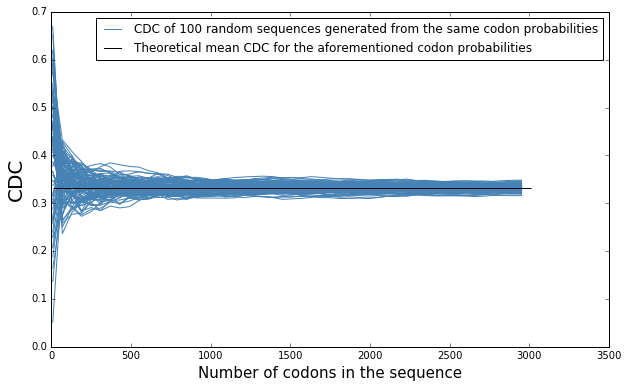

In [15]:
CDC_graph(10, CDCs, cdc_from_probability(randos))

In [16]:
#Generate a codon probability dictionary in which ever codon has the same probability
def equal_probs():
    # building a list of all 61 possible codons
    bases = ['A', 'T', 'G', 'C']
    codons = []
    for one in bases:
        for two in bases:
            for three in bases:
                codons.append(one+two+three)
    codons.remove('TAA')
    codons.remove('TGA')
    codons.remove('TAG')
    
    codon_probabilities = {}
    for codon in codons:
        codon_probabilities[codon] = 1 / len(codons)
    return codon_probabilities

0.004316341654931


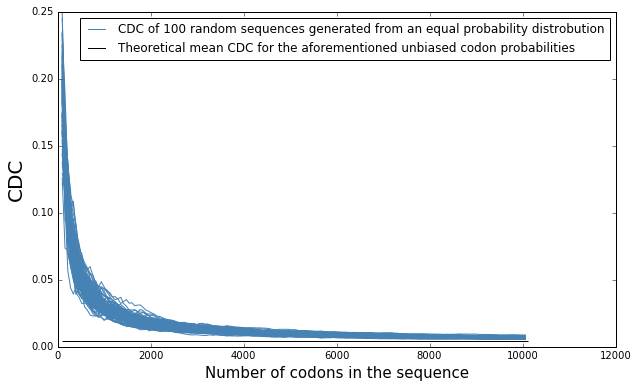

In [11]:
# Graph CDC of 100 random genetic sequences generated from an equal probability distribution

e = equal_probs()

CDCs = []
for x in range(0, 100):
    CDCs.append(CDC_list(100, 10000, e))
CDC_graph(100, CDCs, cdc_from_probability(e), 'CDC of 100 random sequences generated from an equal probability distribution', \
         'Theoretical mean CDC for the aforementioned unbiased codon probabilities')

print(cdc_from_probability(e))

In [17]:
#Generate a codon probability dictionary in which each synonymous codon has the same probability
def no_bias():
    table = CodonTable.unambiguous_dna_by_id[11]
    # building a list of all 61 possible codons
    bases = ['A', 'T', 'G', 'C']
    codons = []
    for one in bases:
        for two in bases:
            for three in bases:
                codons.append(one+two+three)
    codons.remove('TAA')
    codons.remove('TGA')
    codons.remove('TAG')
    
    amino_acids = {}
    codon_probabilities = {}
    for codon in codons:
        amino_acid = table.forward_table[codon]
        if amino_acid in amino_acids:
            amino_acids[amino_acid] += 1
        else:
            amino_acids[amino_acid] = 1
        
    for codon in codons:
        codon_probabilities[codon] = (1 / len(amino_acids)) * (1 / amino_acids[table.forward_table[codon]])
    return codon_probabilities

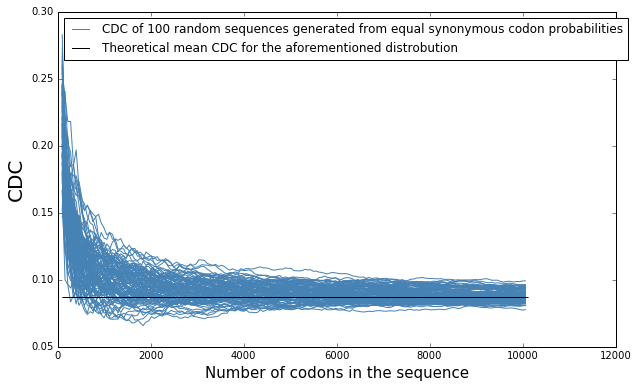

In [18]:
n = no_bias()

CDCs = []
for x in range(0, 100):
    CDCs.append(CDC_list(100, 10000, n))
CDC_graph(100, CDCs, cdc_from_probability(n), 'CDC of 100 random sequences generated from equal synonymous codon probabilities'\
         , 'Theoretical mean CDC for the aforementioned distrobution')

In [19]:
#Generate a codon probability dictionary in which only 1 synonymous codon has a probability of appearing
def max_bias():
    table = CodonTable.unambiguous_dna_by_id[11]
    # building a list of all 61 possible codons
    bases = ['A', 'T', 'G', 'C']
    codons = []
    for one in bases:
        for two in bases:
            for three in bases:
                codons.append(one+two+three)
    codons.remove('TAA')
    codons.remove('TGA')
    codons.remove('TAG')
    
    codon_probabilities = {}
    amino_acids = set()
    for codon in codons:
        amino_acids.add(table.forward_table[codon])
    
    codons_per_acid = []
    for amino_acid in amino_acids:
        syn_codons = []
        for codon in codons:
            if table.forward_table[codon] == amino_acid:
                syn_codons.append(codon)
        codons_per_acid.append(syn_codons)
            
    for acid in codons_per_acid:
        codon_probabilities[random.choice(acid)] = 1 / len(amino_acids)
    
    for codon in codons:
        if codon not in codon_probabilities:
            codon_probabilities[codon] = 0
    
    return codon_probabilities

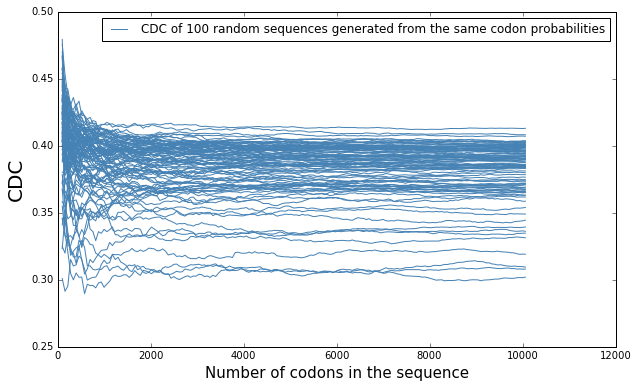

In [50]:
CDCs = []
for x in range(0, 100):
    CDCs.append(CDC_list(100, 10000, max_bias()))
CDC_graph(100, CDCs)

In [22]:
#Generate a codon probability dictionary in which only 1 synonymous codon has a RANDOM probability of appearing
def rand_max_bias():
    table = CodonTable.unambiguous_dna_by_id[11]
    # building a list of all 61 possible codons
    bases = ['A', 'T', 'G', 'C']
    codons = []
    for one in bases:
        for two in bases:
            for three in bases:
                codons.append(one+two+three)
    codons.remove('TAA')
    codons.remove('TGA')
    codons.remove('TAG')
    
    codon_probabilities = {}
    amino_acids = set()
    for codon in codons:
        amino_acids.add(table.forward_table[codon])
    
    codons_per_acid = []
    for amino_acid in amino_acids:
        syn_codons = []
        for codon in codons:
            if table.forward_table[codon] == amino_acid:
                syn_codons.append(codon)
        codons_per_acid.append(syn_codons)
    
    #creating a list of probabilities, all within between 0 to 1
    random_prob = []
    for x in range(0, len(codons_per_acid)):
        random_prob.append(random.uniform(0, 1))
    
    #correcting the probabilities so that they sum to 1
    c = 0
    while sum(random_prob) > 1:
        over = sum(random_prob) / len(random_prob)
        if random_prob[c % len(random_prob)] > over:
            random_prob[c % len(random_prob)] -= over
        c += 1
    else:
        random_prob[random.randint(0, len(random_prob) - 1)] += 1 - sum(random_prob)
    
    c = 0
    for acid in codons_per_acid:
        codon_probabilities[random.choice(acid)] = random_prob[c]
        c += 1
    
    for codon in codons:
        if codon not in codon_probabilities:
            codon_probabilities[codon] = 0
    
    return codon_probabilities

In [23]:
# Graph CDC vs. length of sequence with a color map indicating GC content
def CDC_GC_graph(n, CDCs, theoretical = 0):
    
    norm = colors.Normalize(vmin=0, vmax=1)
    cmap = cm.YlOrRd
    color_map = cm.ScalarMappable(norm = norm, cmap = cmap)
    
    fig = plt.figure( figsize = (10, 6) )
    ax = fig.add_subplot(1,1,1)
    
    ax.set_xlabel("Number of codons in the sequence", fontsize = 15)
    ax.set_ylabel("CDC", fontsize = 20)
    
    plt.grid(False)
    c = True
    for CDC in CDCs:
        x_values = list(range(n, len(CDC[0]) + n))
        for x in range(0, len(x_values)):
            x_values[x] = n + 60 * x
        if c == True: 
            ax.plot(x_values, CDC[0], color = color_map.to_rgba(CDC[1]), zorder=1, \
                   label = 'CDC of 100 random sequences generated from the same codon probabilities')
            c = False
        else:
            ax.plot(x_values, CDC[0], color = color_map.to_rgba(CDC[1]), zorder=1)
    if theoretical != 0:
        ax.hlines(theoretical, n, len(CDC)*60 + n + (len(CDC)/60), label = 'Theoretical mean CDC for the aforementioned codon probabilities')   
    plt.legend(loc = 'best')

    
    #plt.savefig('CDC_v_length.png')

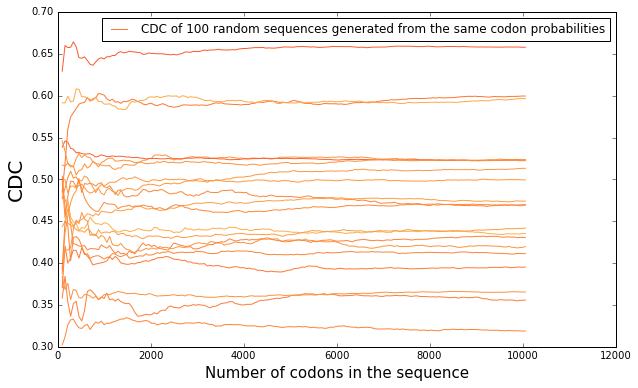

In [24]:
CDCs = []
for x in range(0, 20):
    CDCs.append(CDC_list(100, 10000, rand_max_bias(), GCcontent))
CDC_GC_graph(100, CDCs)

In [15]:
# Import genetic data with varying GC content
jsons = glob.glob('GC_Sequences/*.json')
data = []
for data_file in jsons:
    with open(data_file) as in_file:   
        data.append(json.load(in_file))

CDCs = []
GCs = []
for file in data:
    for seq in file:
        CDCs.append(cdc(seq))
        GCs.append(GCcontent(seq))

In [43]:
# Graph CDC vs. GC content with no confounding variables
def GCvCDC_graph(GCs, CDCs, theoretical = 0):
    
    fig = plt.figure( figsize = (10, 6) )
    ax = fig.add_subplot(1,1,1)
    
    ax.set_xlabel("GC content", fontsize = 15)
    ax.set_ylabel("CDC", fontsize = 20)
    
    plt.grid(False)
    c = True
    
    ax.scatter(GCs, CDCs, color = 'steelblue', zorder=1, label = 'GC content vs CDC')
    
    plt.legend(loc = 'best')
    
    
    #plt.savefig('CDC_v_GC.png')

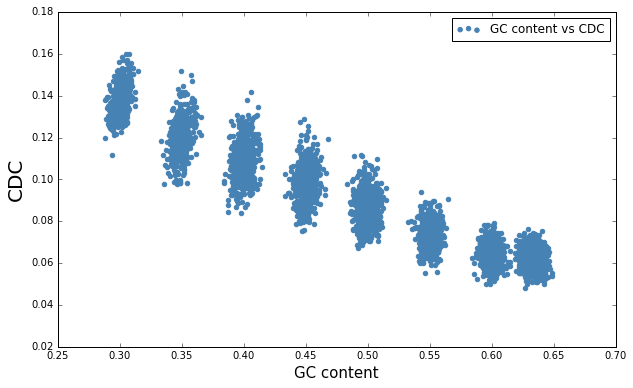

In [18]:
GCvCDC_graph(GCs, CDCs)

In [6]:
# Build a sequence consisting entirely of all 61 codons repeated 30 times
def const_CDC(n = 30):
    # building a list of all 61 possible codons
    bases = ['A', 'T', 'G', 'C']
    codons = []
    for one in bases:
        for two in bases:
            for three in bases:
                codons.append(one+two+three)
    codons.remove('TAA')
    codons.remove('TGA')
    codons.remove('TAG')
    
    all_codons = ''
    for codon in codons:
        all_codons += codon
    CDCs = []
    
    seq = 'AAA'
    for x in range(0, n):
        seq += all_codons
        CDCs.append(cdc((seq + 'TAG')))    
    return CDCs

In [19]:
def graph_const_CDC(CDCs):
    x_values = []
    for x in range(1, len(CDCs) + 1):
        x_values.append(0 + x * 61)
    
    fig = plt.figure( figsize = (10, 6) )
    ax = fig.add_subplot(1,1,1)
    
    ax.set_xlabel("Number of codons in the sequence", fontsize = 15)
    ax.set_ylabel("CDC", fontsize = 20)
    ax.set_ylim([0,.5])
    
    plt.grid(False)
    ax.plot(x_values, CDCs, color = 'steelblue', zorder=1, \
            label = 'CDC of a sequence consisting of all 61 codons repeated 30 times', linewidth = 3)
    
    plt.legend(loc = 'best')
    
    plt.savefig('CDC_all_codons.png')

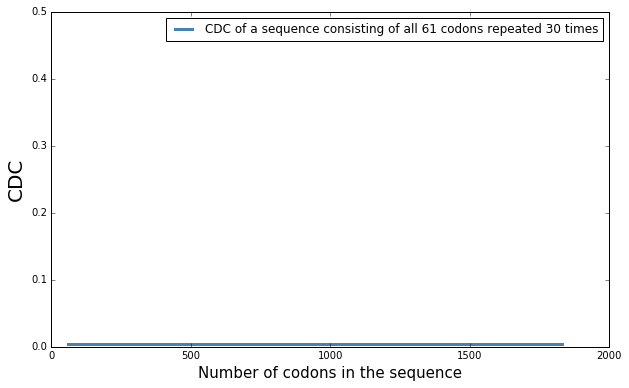

In [20]:
graph_const_CDC(const_CDC())